In [1]:
import os
import random
import numpy as np
from glob import glob
import scipy.io
import shutil
import zipfile
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
from shutil import copy2

IMAGE_SIZE=256
BATCH_SIZE=16
MAX_TRAIN_IMAGES=400


train_low_light_images=sorted(glob("/content/drive/MyDrive/Colab Notebooks/Train/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images=sorted(glob("/content/drive/MyDrive/Colab Notebooks/Train/low/*"))[MAX_TRAIN_IMAGES:]

print("Train Images:", len(train_low_light_images))
print("Validation Images:", len(val_low_light_images))

Train Images: 400
Validation Images: 85


In [ ]:
from PIL import Image
import os
import numpy as np

def convert_images_to_vector(folder_path, target_size=(28, 28)):
  images = []
  for filename in os.listdir(folder_path):
    # Check for supported image extensions (adjust as needed)
    if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
      image_path = os.path.join(folder_path, filename)
      try:
        img = Image.open(image_path)
        # Convert to grayscale if needed (adjust for color handling)
        if img.mode != 'L':
          img = img.convert('L')
        # Resize the image
        img = img.resize(target_size, resample=Image.LANCZOS)  # Consider bicubic or bilinear resampling
        # Convert image to a NumPy array (grayscale will have 1 channel)
        img_array = np.array(img)
        images.append(img_array)
      except (IOError, OSError) as e:
        print(f"Error opening image {filename}: {e}")

  # Convert the list of image arrays to a NumPy array
  image_vector = np.array(images)
  return image_vector

# Example usage
folder_path = "/content/drive/MyDrive/Colab Notebooks/low/"
image_vector = convert_images_to_vector(folder_path)

print(f"Image vector shape: {image_vector.shape}")

Image vector shape: (485, 28, 28)


In [ ]:
train_low_light_images=image_vector[:MAX_TRAIN_IMAGES]
val_low_light_images=image_vector[MAX_TRAIN_IMAGES:]

print("Train Images:", (train_low_light_images.shape))
print("Validation Images:", (val_low_light_images.shape))

Train Images: (400, 28, 28)
Validation Images: (85, 28, 28)


In [ ]:
train_dataset=(train_low_light_images)
val_dataset=(val_low_light_images)

print((train_dataset.shape))
print((val_dataset.shape))

(400, 28, 28)
(85, 28, 28)


In [ ]:
# prepare source data
noise_factor = 0.1

train_dataset_noise = train_dataset + noise_factor * np.random.normal(loc = 0., scale = 1., size = train_dataset.shape)
val_dataset_noise = val_dataset + noise_factor * np.random.normal(loc = 0., scale = 1., size = val_dataset.shape)

In [ ]:
train_dataset_noise.shape

(400, 28, 28)

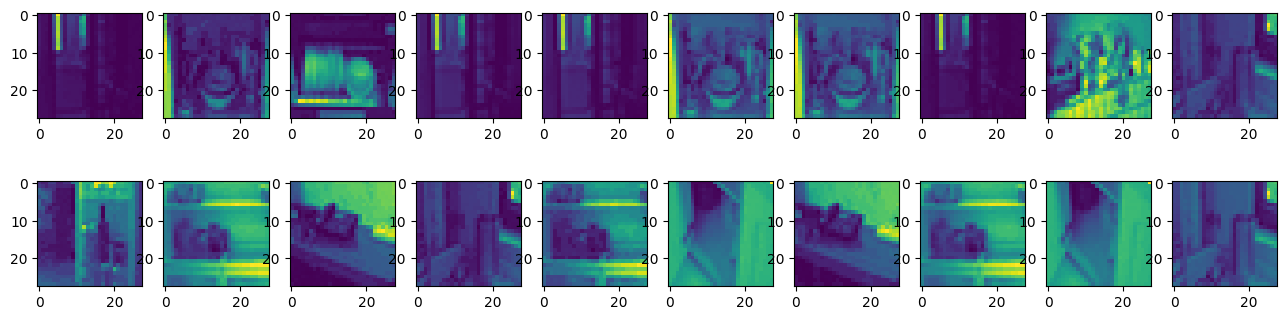

In [ ]:
fig, axes = plt.subplots(2,10, figsize = (16,4))

count = 0
for i in range(2):
    for j in range(10):
        axes[i,j].imshow(train_dataset_noise[count])
        count+=1

In [ ]:
train_dataset = train_dataset.reshape(train_dataset.shape[0], 28 ,28, 1)
val_dataset = val_dataset.reshape(val_dataset.shape[0], 28,28,1)

train_dataset_noise = train_dataset_noise.reshape(train_dataset_noise.shape[0], 28 ,28, 1)
val_dataset_noise = val_dataset_noise.reshape(val_dataset_noise.shape[0], 28,28,1)

train_dataset.shape, train_dataset_noise.shape

((400, 28, 28, 1), (400, 28, 28, 1))

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, UpSampling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

encoder_input = Input(shape = train_dataset.shape[1:])
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2,2), padding = 'same')(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D(pool_size = (2,2), padding = 'same')(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same')(x)

autoencoder = Model(encoder_input, decoded, name = 'Denoising_Model')
autoencoder.summary()

Model: "Denoising_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_24 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_25 (Ba  (None, 14, 14, 32)    

In [ ]:
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [ ]:
checkpoint = ModelCheckpoint("denoising_model.h5", save_best_only=True, save_weights_only=False, verbose = 1)
history = autoencoder.fit(train_dataset_noise, train_dataset, batch_size = 128, epochs = 50, callbacks = checkpoint, validation_split = 0.25, verbose = 2)

Epoch 1/50

Epoch 1: val_loss improved from inf to -27.55846, saving model to denoising_model.h5
3/3 - 4s - loss: 0.3054 - val_loss: -2.7558e+01 - 4s/epoch - 1s/step
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from -27.55846 to -154.70636, saving model to denoising_model.h5
3/3 - 1s - loss: -2.2746e+01 - val_loss: -1.5471e+02 - 1s/epoch - 443ms/step
Epoch 3/50

Epoch 3: val_loss improved from -154.70636 to -354.58804, saving model to denoising_model.h5
3/3 - 1s - loss: -4.1123e+01 - val_loss: -3.5459e+02 - 1s/epoch - 346ms/step
Epoch 4/50

Epoch 4: val_loss improved from -354.58804 to -612.12927, saving model to denoising_model.h5
3/3 - 1s - loss: -5.7383e+01 - val_loss: -6.1213e+02 - 801ms/epoch - 267ms/step
Epoch 5/50

Epoch 5: val_loss improved from -612.12927 to -897.31641, saving model to denoising_model.h5
3/3 - 1s - loss: -7.1106e+01 - val_loss: -8.9732e+02 - 765ms/epoch - 255ms/step
Epoch 6/50

Epoch 6: val_loss improved from -897.31641 to -1183.91821, saving model to denoising_model.h5
3/3 - 1s - loss: -8.3593e+01 - val_loss: -1.1839e+03 - 777ms/epoch - 259ms/step
Epoch 7/50

Epoch 7: val_loss improved from -1183.91821 to -1396.17822, saving model to deno

In [ ]:
# load best performance model
from keras.models import load_model
autoencoder = load_model('denoising_model.h5')
autoencoder.summary()

Model: "Denoising_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_12 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_13 (Ba  (None, 14, 14, 32)    

In [ ]:
def visualize_data(data, row, column):
    data = data.reshape(data.shape[0], 28,28)
    count = 0
    fig, axes = plt.subplots(row, column, figsize = (16,4))
    for i in range(row):
        for j in range(column):
            axes[i,j].imshow(data[count])
            count+=1

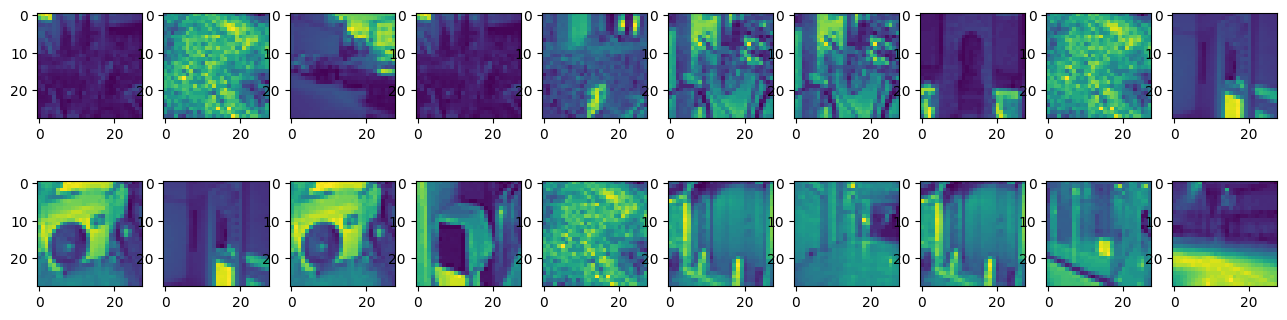

In [ ]:
visualize_data(val_dataset_noise[:20], 2,10)

In [ ]:
pred = autoencoder.predict(val_dataset_noise)
pred.shape

3/3 [==============================] - 0s 17ms/step


(85, 28, 28, 1)

In [ ]:
visualize_data(pred, 2,10)

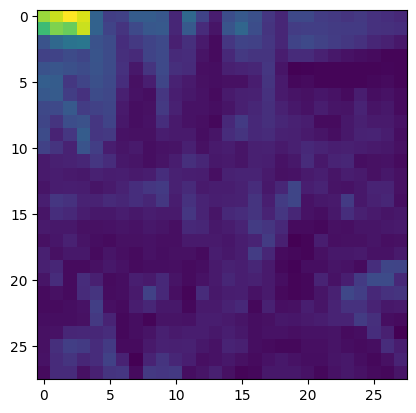

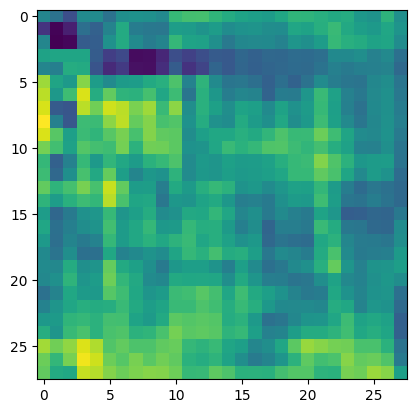

In [ ]:
original_Image=val_dataset_noise[0]
enhanced_Image=pred[0]
plt.imshow(original_Image)
plt.show()
plt.imshow(enhanced_Image)
plt.show()

In [ ]:
def PSNR(gt, image):
    """"Function to calculate peak signal-to-noise ratio (PSNR) between two images."""
    # height, width , channels= gt.shape
    # gt=cv2.resize(gt, (width//40*40,height//40*40), interpolation=cv2.INTER_CUBIC)
    mse = np.mean((gt - image) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(255.0 / (np.sqrt(mse)))

In [ ]:
import cv2
sum=0
for i in range(len(val_dataset_noise)):
    print(PSNR(val_dataset_noise[i],autoencoder.predict(val_dataset_noise[i])))
    sum+=PSNR(val_dataset_noise[i],autoencoder.predict(val_dataset_noise[i]))
print(sum/len(val_dataset_noise))

InvalidArgumentError: Graph execution error:

Detected at node Denoising_Model/conv2d_30/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-246-4ca62d6abbcc>", line 4, in <cell line: 3>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

convolution input must be 4-dimensional: [28,28,1]
	 [[{{node Denoising_Model/conv2d_30/Relu}}]] [Op:__inference_predict_function_94630]